# Personalisation and Machine Learning Assignment 2

In this notebook, adapted from the Week 6.1 lab activity, I will be going over the embeddings recommendation and using it to create statistics and visualisations for the movie dataset.

In [1]:
## IMPORT CELL ##
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch

## Load in Data into Notebook

In [2]:
df = pd.read_csv("data/ml-latest-small/ratings.csv")
len(df)

100004

In [3]:
df.tail(100)

,userId,movieId,rating,timestamp
99904,671,590,4.0,1065149296
99905,671,608,4.0,1064890575
99906,671,745,4.0,1065149085
99907,671,919,4.0,1065149458
99908,671,1035,5.0,1065149492
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


Now, use .unique() to create the vocabulary for the dataset.

In [4]:
#Use the unique() function to get the total number of unique users and movies 
#(essentially removing duplicates)
user_ids = df["userId"].unique().tolist()   #Puts unique user IDs into a list
movie_ids = df["movieId"].unique().tolist()  #Puts unique movie IDs into a list

In [5]:
print('There are', len(movie_ids), 'movies in this dataset and', len(user_ids), 'users')

There are 9066 movies in this dataset and 671 users


In [6]:
#Make a dictionary mapping ids (keys, x) to indexes (values, i)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

Then the user and movie indexes are added to our original dataframe.

In [7]:
#Make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [8]:
df.head(5)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,2.5,1260759144,0,0
1,1,1029,3.0,1260759179,0,1
2,1,1061,3.0,1260759182,0,2
3,1,1129,2.0,1260759185,0,3
4,1,1172,4.0,1260759205,0,4


In [9]:
#Scale ratings data to be in the range [0,1]
#This makes things easier
from sklearn.preprocessing import MinMaxScaler
##Pick the range\
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))
df["rating"].describe()

count    100004.000000
mean          0.676357
std           0.235125
min           0.000000
25%           0.555556
50%           0.777778
75%           0.777778
max           1.000000
Name: rating, dtype: float64

In [10]:
#Check the dataframe
df.head(5)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,0.444444,1260759144,0,0
1,1,1029,0.555556,1260759179,0,1
2,1,1061,0.555556,1260759182,0,2
3,1,1129,0.333333,1260759185,0,3
4,1,1172,0.777778,1260759205,0,4


## Prepare Data and Model for Training

As this is a predictive model, first we need to split the data into a training set and a test set (90:10 split).

In [12]:
from sklearn.model_selection import train_test_split
#Inputs
x = df[["user_index", "movie_index"]]
#Outputs
y = df["rating"]
#Get train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

Now we can build our model using PyTorch.

In [13]:
## DEFINE THE MODEL ##

class RecommenderNet(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_size)
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.movie_embedding = torch.nn.Embedding(num_movies, embedding_size)
        self.movie_bias = torch.nn.Embedding(num_movies, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, inputs):
        #Split out indexes 
        user_indexes = inputs[:, 0]
        movie_indexes = inputs[:, 1]
        #Forward pass on embedding layer
        user_vector = self.user_embedding(user_indexes)
        user_bias = self.user_bias(user_indexes).flatten()
        movie_vector = self.movie_embedding(movie_indexes)
        movie_bias = self.movie_bias(movie_indexes).flatten()
        #Dot product
        dot = (user_vector * movie_vector).sum(1)
        with_bias = dot + user_bias + movie_bias
        #Activation function
        output = self.sig(with_bias)
        return output

In [15]:
## SET UP THE MODEL ##

#Pick Embedding size
EMBEDDING_SIZE = 16
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

## Training the Model

Now that the model has been set up and our dataset split, we can now run the model to get the predicted ratings.

In [16]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#Make a subclass to hold our dataset (movie - user pairs (input) and a rating (label))
class MoviesDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.IntTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [59]:
#Use our train - validation split to make DataLoader objects
train_dl = DataLoader(MoviesDataset(x_train.values,y_train.values), batch_size=64, shuffle=True)
validation_dl = DataLoader(MoviesDataset(x_test.values,y_test.values), batch_size=64, shuffle=True)

In [60]:
epochs = 20
#Use Mean Squared Error as a loss function
loss_fn = torch.nn.MSELoss() 
#Use the Adam algorithm to update the weights based on the loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [61]:
#Use a for loop to repeat for the desired number of epochs 
for i in range(epochs):
    
    model.train(True)
    
    #Use a for loop for each batch (provided by the Dataloader)
    running_loss = 0.0
    for (index, batch) in enumerate(train_dl):
        
        #Get batch 
        inputs, labels = batch
        model.zero_grad()
        
        #Forward pass
        prediction = model(inputs)
        
        #Get Loss
        loss = loss_fn(prediction, labels)
        
        #Update weights (back prop)
        loss.backward()
        optimizer.step()
        running_loss += loss
    
    avg_loss = running_loss / (index + 1)

    model.train(False)

    #Now try with the validation set (no need to update weights, just get loss)
    running_vloss = 0.0
    for index, vdata in enumerate(validation_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print('Loss {} Validation Loss {}'.format(avg_loss, avg_vloss))

Loss 0.17260390520095825 Validation Loss 0.11256545037031174
Loss 0.07693872600793839 Validation Loss 0.08177712559700012
Loss 0.04851844906806946 Validation Loss 0.06980355829000473
Loss 0.036795999854803085 Validation Loss 0.06476811319589615
Loss 0.031050587072968483 Validation Loss 0.06309590488672256
Loss 0.02736131101846695 Validation Loss 0.0624375194311142
Loss 0.025163963437080383 Validation Loss 0.06107046827673912
Loss 0.023636868223547935 Validation Loss 0.06305041164159775
Loss 0.022482216358184814 Validation Loss 0.060953181236982346
Loss 0.021611124277114868 Validation Loss 0.06212480366230011
Loss 0.020930150523781776 Validation Loss 0.06223175674676895
Loss 0.020223604515194893 Validation Loss 0.062288012355566025
Loss 0.01988723687827587 Validation Loss 0.06208949536085129
Loss 0.01964854635298252 Validation Loss 0.062324099242687225
Loss 0.01930326782166958 Validation Loss 0.06325739622116089
Loss 0.019099978730082512 Validation Loss 0.06365828216075897
Loss 0.018904

Just in case, I will save the weights of the model in case I need it later in the notebook.

In [62]:
torch.save(model.state_dict(), 'my_rating_model_weights.pth')

In [17]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.load_state_dict(torch.load('my_rating_model_weights.pth'))
model.eval()

RecommenderNet(
  (user_embedding): Embedding(671, 16)
  (user_bias): Embedding(671, 1)
  (movie_embedding): Embedding(9066, 16)
  (movie_bias): Embedding(9066, 1)
  (sig): Sigmoid()
)

## TASK 1: Create Predicted Statisitcs

With our model trained, we can now create predicted ratings. This will allow us to create our **DIVERSITY** and **NOVELTY** statistics. We would not really need the movie names for this, we just need index to check the similarities.

In [18]:
#Get the movie data so we can map back to names
movie_data = pd.read_csv("data/ml-latest-small/movies.csv")
movie_data.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [19]:
def get_top_n(user = 0, n = 10): 
    #Get Movie Names
    top_n_indexes = get_top_n_indexes(user, n)
    top_n = get_names_for_indexes(top_n_indexes)
    return top_n

def get_names_for_indexes(indexes):
    return [movie_data[movie_data["movieId"]==movie_ids[i]]["title"].item() for i in indexes]

def get_top_n_indexes(user = 0, n = 10):
    #For one user, make a pair with every movie index
    x = torch.IntTensor([[user, i] for i in np.arange(num_movies)])
    #Predict 
    predicted_ratings = model(x)
    #Get Top-N indexes
    top_n_indexes = predicted_ratings.argsort()[-n:]
    return top_n_indexes


### DIVERSITY STATISTIC ###
#### Test Code on 1 User ####

Before we can find the diversity of the entire dataset, it would be best to test it on one user first, then extend it to two users.

In [20]:
#Test_user_1 = 36

#Random users top 10
print(get_top_n(36)) ## top 10 movies

print(get_top_n_indexes(36))  ##top 10 movie indexes

['Green for Danger (1946)', 'College (1927)', 'Sammy and Rosie Get Laid (1987)', "Darby O'Gill and the Little People (1959)", 'Willie & Phil (1980)', 'Soul Man (1986)', 'Vampyros Lesbos (Vampiras, Las) (1971)', 'Play House, The (1921)', 'Cops (1922)', 'Land of Silence and Darkness (Land des Schweigens und der Dunkelheit) (1971)']
tensor([8550, 6182, 7937, 4410, 8240, 5627, 5734, 7454, 7456, 7432])


In [21]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.preprocessing import StandardScaler

In [22]:
test_arr_1 = get_top_n(36)
test_arr_2 = get_top_n_indexes(36)
test_arr_2

tensor([8550, 6182, 7937, 4410, 8240, 5627, 5734, 7454, 7456, 7432])

In [23]:
# Calculate the similarity matirx of the test user
#Standardise
scaled_films = StandardScaler().fit_transform(test_arr_2.reshape(-1, 1))
#Get cosine similarities
similarities = cosine(scaled_films)
similarities

array([[ 1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1.],
       [ 1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1.],
       [ 1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1.],
       [-1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1.],
       [ 1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.],
       [ 1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.],
       [ 1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.]])

In [24]:
#Cosine distance = 1 - Cosine similarity
#If two movies are similar (i.e cosine simiarity is 1), 
#then there would be no distance between them (i.e. cosine difference is 0)
#Therefore, by subtracting the similarity by 1, we can find how far the movies are from one another
distance = 1 - similarities

In [25]:
distance

array([[0., 2., 0., 2., 0., 2., 2., 0., 0., 0.],
       [2., 0., 2., 0., 2., 0., 0., 2., 2., 2.],
       [0., 2., 0., 2., 0., 2., 2., 0., 0., 0.],
       [2., 0., 2., 0., 2., 0., 0., 2., 2., 2.],
       [0., 2., 0., 2., 0., 2., 2., 0., 0., 0.],
       [2., 0., 2., 0., 2., 0., 0., 2., 2., 2.],
       [2., 0., 2., 0., 2., 0., 0., 2., 2., 2.],
       [0., 2., 0., 2., 0., 2., 2., 0., 0., 0.],
       [0., 2., 0., 2., 0., 2., 2., 0., 0., 0.],
       [0., 2., 0., 2., 0., 2., 2., 0., 0., 0.]])

In [26]:
#Create a function that will find the mean of the cosine difference matrix
#Code adapted from https://www.geeksforgeeks.org/mean-median-matrix/
N = 10
def matrix_mean(a):
    summ = 0
    for i in range(N):
        for j in range(N):
            summ += a[i][j]
    return summ/(N*N)

In [27]:
#Mean difference of test user
test_result = matrix_mean(distance)
test_result

0.96

#### Test Code on 2 users ####

In [28]:
#Test users will be users 36 and 50
#Aim is to get a figure that measures the diversity of recommendations between both users

Test_Users = [36,50]

#Create empty list to put each test users mean difference
mean_diffs=[]

for item in Test_Users:
    topn_indexes = get_top_n_indexes(item)
    #Standardise
    scaled_films = StandardScaler().fit_transform(topn_indexes.reshape(-1, 1))
    #Get cosine similarity, then subtract from 1 to get the difference
    similarities = cosine(scaled_films)
    distance = 1 - similarities
    #call matrix_mean to find mean difference of top 10 and append to mean_diff array
    mean_diffs.append(matrix_mean(distance))


In [29]:
print(mean_diffs, 'are the mean differences of the test useres top 10s')
from statistics import mean
print(round(mean(mean_diffs),3), 'is the diverity statistic of the test users')

[0.96, 0.84] are the mean differences of the test useres top 10s
0.9 is the diverity statistic of the test users


#### Use Code on entire dataset ####

As the code written can work relatively well with two users, we can now find the diversity statistic of the entire dataset.

In [30]:
#Create empty list to put each test users mean difference
mean_diffs_fulldf=[]

for i in range(num_users):
    topn_indexes = get_top_n_indexes(i)
    #Standardise
    scaled_films = StandardScaler().fit_transform(topn_indexes.reshape(-1, 1))
    #Get cosine similarity, then subtract from 1 to get the difference
    similarities = cosine(scaled_films)
    distance = 1 - similarities
    #call matrix_mean to find mean difference of top 10 and append to mean_diff array
    mean_diffs_fulldf.append(matrix_mean(distance))

diversity = round(mean(mean_diffs_fulldf),3)

print('The diversity statistic of the whole dataset is', diversity)

The diversity statistic of the whole dataset is 0.928


From the result, the mean diversity between each film in every users Top 10 is very high, so we can conclude that users, on average, users tend not to get the same sort of movies in their recommendations.

### NOVELTY STATISTIC ###

Now, we will need to find the mean popularity of the films in every users recommendations. To do that, we will need the actual ratings data of the movies.

In [31]:
#Load data into notebook for non-standardised ratings
ratings_df = pd.read_csv("data/ml-latest-small/ratings.csv")

In [32]:
print(ratings_df.columns)
ratings_df.head(5)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [34]:
#TEST CELL
get_top_n(1)

['Curiosity of Chance, The (2006)',
 'Nights of Cabiria (Notti di Cabiria, Le) (1957)',
 "Mummy's Ghost, The (1944)",
 'Something Wild (1986)',
 'Diabolique (Les diaboliques) (1955)',
 'Cops (1922)',
 'People Will Talk (1951)',
 'Ice Princess (2005)',
 'Secretariat (2010)',
 'Making a Murderer (2015)']

In [35]:
test_arr = get_top_n_indexes(36)

In [45]:
#Empty list for the mean ratings of each film in test user's top 10
film_rating=[]

for index in test_arr:
    for movieId, rating in zip(ratings_df['movieId'], ratings_df['rating']):
        #empty list for all the ratings of each movie in recommendation
        rates=[]
        if movieId == movie_ids[index]:
            rates.append(rating)
            av_rate = mean(rates)  #find mean rating of each movie
    film_rating.append(av_rate)

print('Average ratings of the recommended films:')
print(film_rating)
print('Mean rating of top 10 movies is')
print(mean(film_rating))


Average ratings of the recommended films:
[5.0, 4.0, 5.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0]
Mean rating of top 10 movies is
4.7


Now, the code needs to be extended to two users (if it can work for two users, we'll be able to do this over the entire dataset).

In [37]:
#Test users will be users 36 and 50
#Aim is to get a figure that measures the novelty of recommendations between both users

Test_Users = [36,50]

#Create empty list to put each test users mean ratings
mean_ratings=[]

for item in Test_Users:
    topn_indexes = get_top_n_indexes(item)
    film_rating=[]
    for index in topn_indexes:
        for movieId, rating in zip(ratings_df['movieId'], ratings_df['rating']):
            #empty list for all the ratings of each movie in recommendation
            rates=[]
            if movieId == movie_ids[index]:
                rates.append(rating)
                av_rate = mean(rates)  #find mean rating of each movie
        film_rating.append(av_rate)
    topten_av = mean(film_rating)
    mean_ratings.append(topten_av)

print('The mean ratings for each user top 10')
print(mean_ratings)
print('The mean rating between the two users is')
print(mean(mean_ratings))

The mean ratings for each user top 10
[4.7, 3.85]
The mean rating between the two users is
4.275


Now extend code to entire dataset.

In [133]:
## THIS WAS TAKING TOO LONG ##
## HAD TO SPLIT THE CODE FOR IT TO WORK FASTER ##

#Create empty list to put each test users mean ratings
mean_ratings=[]

for item in range(num_users):
    topn_indexes = get_top_n_indexes(item)
    film_rating=[]
    for index in topn_indexes:
        for movieId, rating in zip(ratings_df['movieId'], ratings_df['rating']):
            rates=[]
            if movieId == movie_ids[index]:
                rates.append(rating)
                av_rate = mean(rates)
        film_rating.append(av_rate)
    topten_av = mean(film_rating)
    mean_ratings.append(topten_av)

In [134]:
mean_rating_fulldf= mean(mean_ratings)
novelty = round(mean_rating_fulldf,3)
print('The nolvelty statistic of the whole dataset is', novelty)

The nolvelty statistic of the whole dataset is 4.514


## TASK 2: Top 30 Best Rated Films

It would be interesting to see the 30 best rated films of this dataset. Unfortunately, the dataset is a bit biased - some films only have one rating which means there are some films with an _average_ rating of 5.

To balance out the dataset, we can remove the films with only one rating, there by removing the heavily biased films.

### Step 1: Remove 1-rating films

In [174]:
# Add movie indexes to ratings_df to help with 
# finding the mean ratings of the movies

ratings_df["movie_index"] = [movie_id_to_index[i] for i in ratings_df["movieId"]]
ratings_df.head()

,userId,movieId,rating,timestamp,movie_index
0,1,31,2.5,1260759144,0
1,1,1029,3.0,1260759179,1
2,1,1061,3.0,1260759182,2
3,1,1129,2.0,1260759185,3
4,1,1172,4.0,1260759205,4


In [175]:
# Note that there are 9066 movies in the dataset
# Resulting array shouldn't be longer than 9066

movie_ratings = []

for x, y in movie_id_to_index.items():
    film_rates = []
    for i, rating in zip(ratings_df['movie_index'], ratings_df['rating']):
        if y == i:
            film_rates.append(rating)
            avg = mean(film_rates)
    movie_ratings.append(avg)
            

In [176]:
# len(movie_ratings) 
# Has 9066 elements in array, for loop was successful

9066

In [177]:
# Create new dataframe with movieID, title and average rankings

film_df = pd.DataFrame(movie_id_to_index.items(), columns=['MovieId', 'Movie_index'])
film_df['av_rating'] = movie_ratings # add in mean ratings
film_df = film_df.sort_values(by=['MovieId'], ascending=True) #Makes adding in titles easier
film_df['title'] = movie_data['title']

In [180]:
# Check dataframe
film_df.head()

,MovieId,Movie_index,av_rating,title
417,1,417,3.872470,"House of the Spirits, The (1993)"
650,2,650,3.401869,Eraser (1996)
319,3,319,3.161017,Cobb (1994)
2084,4,2084,2.384615,Entrapment (1999)
651,5,651,3.267857,"Gate of Heavenly Peace, The (1995)"


In [181]:
original = len(film_df)
print('Originally, there were', original, 'movies in the dataset')

Originally, there were 9066 movies in the dataset


In [182]:
# Remove all the movies that have an average rating of 5

film_df.drop(film_df.index[(film_df["av_rating"] == 5)],axis=0,inplace=True)

In [183]:
new = len(film_df)
print('There are', original - new, 'movies with biased ratings')
print('After removal, there are', new, 'acurately reviewed movies')

There are 315 movies with biased ratings
After removal, there are 8751 acurately reviewed movies


In [184]:
# With biased ratings removed, we can sort the dataframe
# To give us the top 30 best rated films

film_df = film_df.sort_values(by=['av_rating'], ascending=False)
film_df.head()

,MovieId,Movie_index,av_rating,title
4347,6273,4347,4.833333,So Fine (1981)
5591,5498,5591,4.750000,Hardcore (1979)
2031,7700,2031,4.750000,Avalanche (1978)
4141,2673,4141,4.750000,Sunshine State (2002)
3165,31435,3165,4.750000,"Time Machine, The (1960)"


In [188]:
# Put first 30 rows in newly order dataframe into new dataframe

top30_films_df = film_df.iloc[:30]
top30_films_df

,MovieId,Movie_index,av_rating,title
4347,6273,4347,4.833333,So Fine (1981)
5591,5498,5591,4.750000,Hardcore (1979)
2031,7700,2031,4.750000,Avalanche (1978)
4141,2673,4141,4.750000,Sunshine State (2002)
3165,31435,3165,4.750000,"Time Machine, The (1960)"
4162,8199,4162,4.750000,"Kid Stays in the Picture, The (2002)"
4547,6375,4547,4.750000,Basic (2003)
6525,4696,6525,4.750000,Everyone's Hero (2006)
3879,50641,3879,4.750000,Fritz the Cat (1972)
6023,117192,6023,4.750000,Beastmaster 2: Through the Portal of Time (1991)


### Step 2: PCA and data plotting

Now that we have the 30 best rated films from the dataset, we can use the movie embeddings to plot the films. However, the dimensionality will be reduced using PCA to plot the data on a graph. 

In [191]:
# Testing how to get a particualr movie's embeddings

model.movie_embedding(torch.LongTensor([9065])).detach().numpy()

array([[-0.643689  , -1.4262347 ,  1.5513606 , -1.3966458 ,  0.41420734,
         1.0883741 , -1.1631967 ,  1.0430999 ,  1.6423582 ,  1.1914515 ,
         0.58689773,  0.3531035 , -0.34539467, -0.99526113, -0.10749001,
         0.23449814]], dtype=float32)

In [189]:
# Get the top movies' indexes into an array

top30_indexes = top30_films_df['Movie_index'].to_numpy()
top30_indexes

array([4347, 5591, 2031, 4141, 3165, 4162, 4547, 6525, 3879, 6023, 5802,
       7220, 5686, 6204, 5248, 5983, 4214, 2408, 6203, 6295, 2496, 3462,
       3017, 3630, 5698, 4218, 2026, 6227, 4528, 6296], dtype=int64)

In [197]:
# Use movie indexes to get corresponding movie embeddings

# Create empty list
top30_embeds = []

# Use for loop to get embeddings into new array
for i in top30_indexes:
    j = model.movie_embedding(torch.LongTensor([i])).detach().numpy()
    top30_embeds.append(j)

top30_embeds # code was successful

[array([[-0.6314163 ,  2.3597052 , -1.7421211 ,  2.1610181 ,  1.8816898 ,
         -0.08990077,  3.370883  , -3.6655815 , -0.01660052, -0.9664951 ,
          0.04576395,  0.28664088,  0.6060768 ,  1.3054297 ,  1.0544823 ,
          1.0606045 ]], dtype=float32),
 array([[ 0.03030334, -0.69994897, -0.76798517, -0.5561217 , -1.1364087 ,
         -0.25634298, -1.1918194 , -0.2835152 , -0.15474245,  1.7580749 ,
         -1.7415599 ,  0.46467432,  0.8630221 , -0.29429832, -0.97566146,
         -0.15403387]], dtype=float32),
 array([[-0.77073485,  0.3737216 , -0.7062403 , -0.38944423, -0.68931776,
          2.2864964 ,  0.09557462, -0.40004846,  1.0905628 , -0.3888272 ,
          0.8585681 ,  0.8837716 ,  2.8488607 ,  0.93448746, -0.90478987,
          1.2031305 ]], dtype=float32),
 array([[-1.1113237 ,  1.7189442 , -0.2591531 , -1.957746  ,  1.1349894 ,
         -2.3356469 ,  0.4594822 , -2.7689993 ,  0.44762507,  0.39132738,
         -0.26324138, -0.06357633,  0.12472913, -0.04347894, -0.10

PCA will be used to reduce the dimensionality of the data.

In [212]:
# Convert list into numpy array

top30_embeds_arr = np.array(top30_embeds)
top30_embeds_arr.shape

(30, 1, 16)

In [215]:
# Reshape array to 2 dimensions so that PCA can work
top30_embeds_4_pca = top30_embeds_arr.reshape(-1,16)

N = 2 

#Reduce dimensions
pca = PCA(n_components=N)
embeds_2d = pca.fit_transform(top30_embeds_4_pca)

# Check array
#embeds_2d

<Figure size 800x800 with 0 Axes>

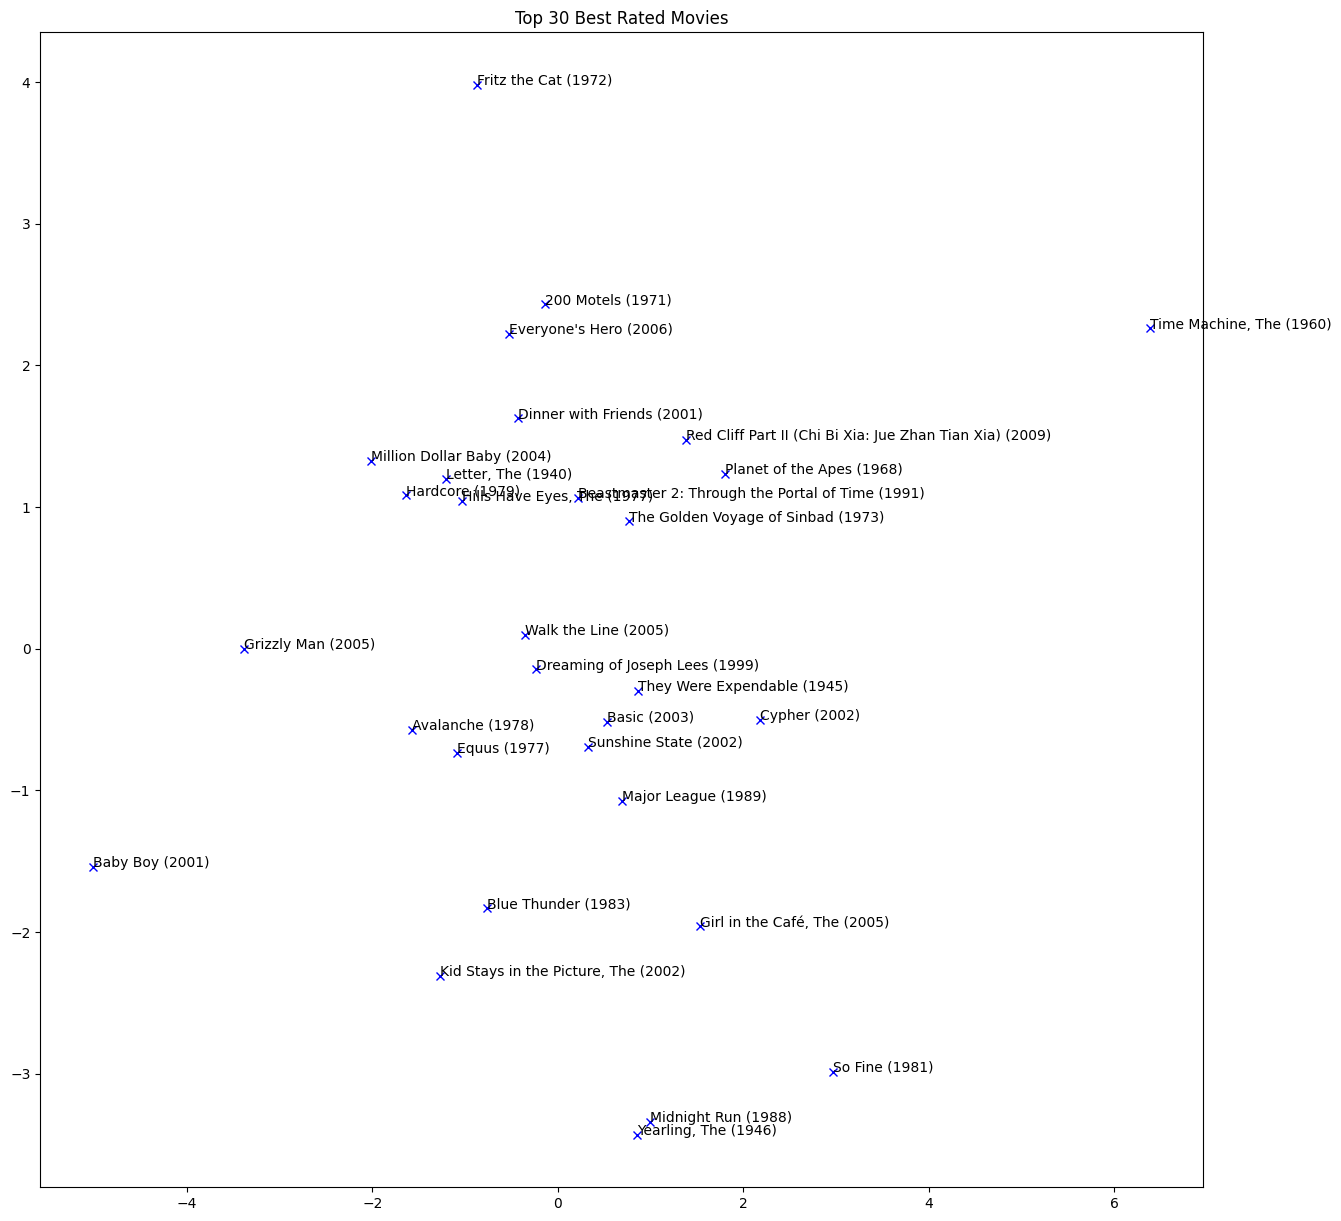

In [221]:
# Plot the movies

plt.figure(figsize=(8, 8))
fig,ax = plt.subplots(figsize=(15,15))
x = embeds_2d[:,0]
y = embeds_2d[:,1]
ax.plot(x,y,"bx")
annotations = top30_films_df['title']
for i, label in enumerate(annotations):
    ax.annotate(label, (x[i], y[i]),alpha=1)
plt.title('Top 30 Best Rated Movies')
plt.show()